In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os

zip_path = "/content/drive/MyDrive/archive (1).zip"
extract_path = "/content/cotton_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['cotton']

In [ ]:
import numpy as np
import cv2, os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

import matplotlib.pyplot as plt
import random


Dataset loaded: (1711, 224, 224, 3) (1711,)


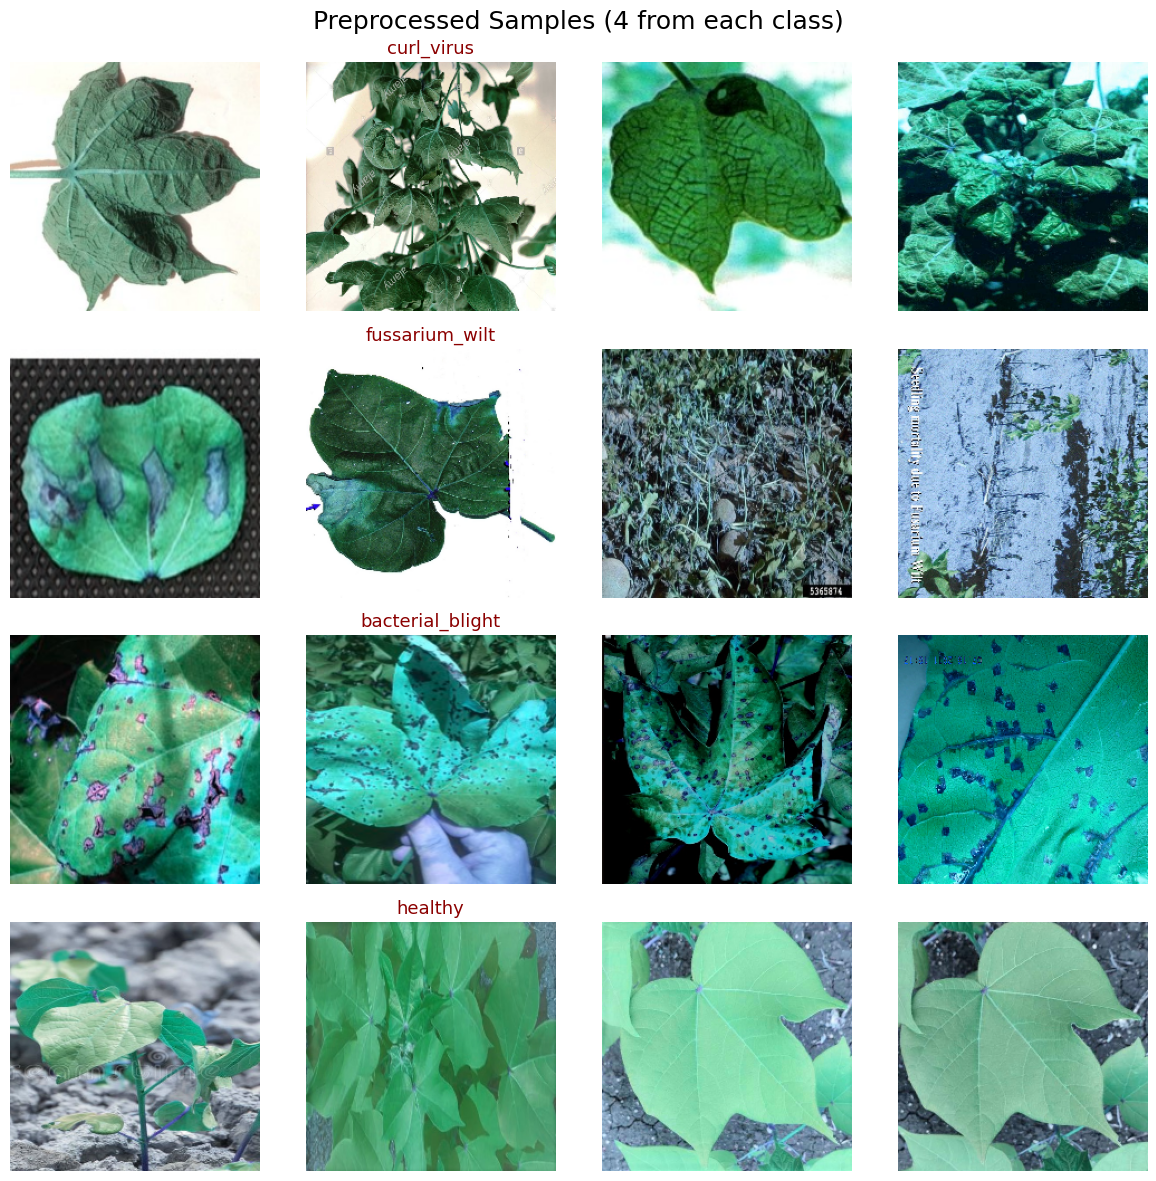

In [ ]:
extract_path = "/content/cotton_dataset/cotton"
categories = ["curl_virus", "fussarium_wilt", "bacterial_blight", "healthy"]
img_size = 224

data, labels = [], []

for category in categories:
    path = os.path.join(extract_path, category)
    class_label = categories.index(category)
    for img in os.listdir(path):
        try:
            img_path = os.path.join(path, img)
            img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_array = cv2.resize(img_array, (img_size, img_size))
            data.append(img_array)
            labels.append(class_label)
        except:
            pass

data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

print("Dataset loaded:", data.shape, labels.shape)

samples_per_class = 4
plt.figure(figsize=(12, 12))

for idx, category in enumerate(categories):
    class_indices = np.where(labels == idx)[0]
    sample_indices = random.sample(list(class_indices), min(samples_per_class, len(class_indices)))

    for i, img_idx in enumerate(sample_indices):
        plt.subplot(len(categories), samples_per_class, idx * samples_per_class + i + 1)
        plt.imshow(data[img_idx])
        plt.axis("off")
        if i == 1:
            plt.title(category, fontsize=13, color="darkred")

plt.suptitle("Preprocessed Samples (4 from each class)", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                    random_state=42, stratify=labels)

In [ ]:
def extract_features(base_model, X):
    model = Model(inputs=base_model.input,
                  outputs=GlobalAveragePooling2D()(base_model.output))
    features = model.predict(X, batch_size=32, verbose=1)
    return features

In [ ]:
vgg_base = VGG16(include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
resnet_base = ResNet50(include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
dense_base = DenseNet121(include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
X_train_vgg = extract_features(vgg_base, X_train)
X_test_vgg  = extract_features(vgg_base, X_test)

X_train_resnet = extract_features(resnet_base, X_train)
X_test_resnet  = extract_features(resnet_base, X_test)

X_train_dense = extract_features(dense_base, X_train)
X_test_dense  = extract_features(dense_base, X_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 731s 17s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 185s 17s/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step


In [ ]:
X_train_concat = np.concatenate([X_train_vgg, X_train_resnet, X_train_dense], axis=1)
X_test_concat  = np.concatenate([X_test_vgg, X_test_resnet, X_test_dense], axis=1)

print("Train shape:", X_train_concat.shape)
print("Test shape:", X_test_concat.shape)


Train shape: (1368, 3584)
Test shape: (343, 3584)


In [ ]:

clf1 = LogisticRegression(max_iter=5000)
clf2 = SVC(probability=True, kernel="rbf")
clf3 = RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:

voting_clf = VotingClassifier(
    estimators=[("lr", clf1), ("svc", clf2), ("rf", clf3)],
    voting="soft"
)

voting_clf.fit(X_train_concat, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=5000)),
                             ('svc', SVC(probability=True)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

y_pred = voting_clf.predict(X_test_concat)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

specificity = TN / (TN + FP)
fpr = FP / (FP + TN)
per_class_acc = (TP + TN) / (TP + TN + FP + FN)

results = []
for idx, cls in enumerate(categories):
    results.append({
        "Class": cls,
        "Precision": report[cls]["precision"],
        "Recall (Sensitivity)": report[cls]["recall"],
        "Specificity": specificity[idx],
        "F1-Score": report[cls]["f1-score"],
        "FPR": fpr[idx],
        "Support": report[cls]["support"],
        "Accuracy": per_class_acc[idx]
    })

results.append({
    "Class": "Overall",
    "Precision": prec,
    "Recall (Sensitivity)": rec,
    "Specificity": "-",
    "F1-Score": f1,
    "FPR": "-",
    "Support": cm.sum(),
    "Accuracy": acc
})

df_results = pd.DataFrame(results)

print("\nDetailed Metrics:\n")
print(df_results.to_string(index=False))


Confusion Matrix:
[[83  1  0  0]
 [ 0 83  1  0]
 [ 0  1 89  0]
 [ 0  0  0 85]]

Detailed Metrics:

           Class  Precision  Recall (Sensitivity) Specificity  F1-Score       FPR  Support  Accuracy
      curl_virus   1.000000              0.988095         1.0  0.994012       0.0     84.0  0.997085
  fussarium_wilt   0.976471              0.988095    0.992278  0.982249  0.007722     84.0  0.991254
bacterial_blight   0.988889              0.988889    0.996047  0.988889  0.003953     90.0  0.994169
         healthy   1.000000              1.000000         1.0  1.000000       0.0     85.0  1.000000
         Overall   0.991340              0.991270           -  0.991287         -    343.0  0.991254


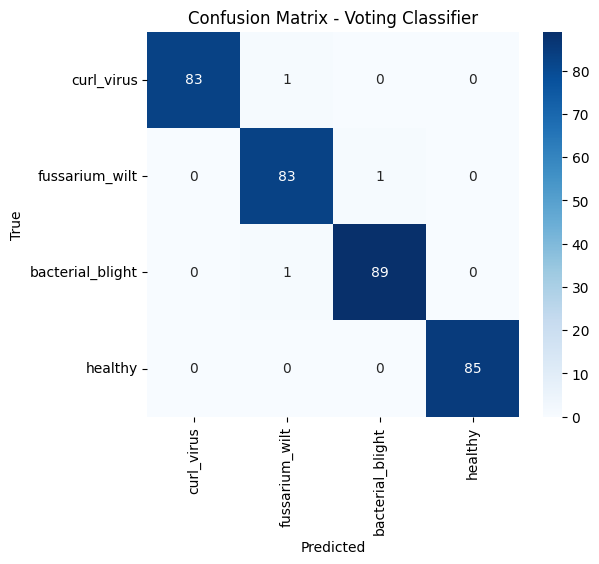

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Voting Classifier")
plt.show()

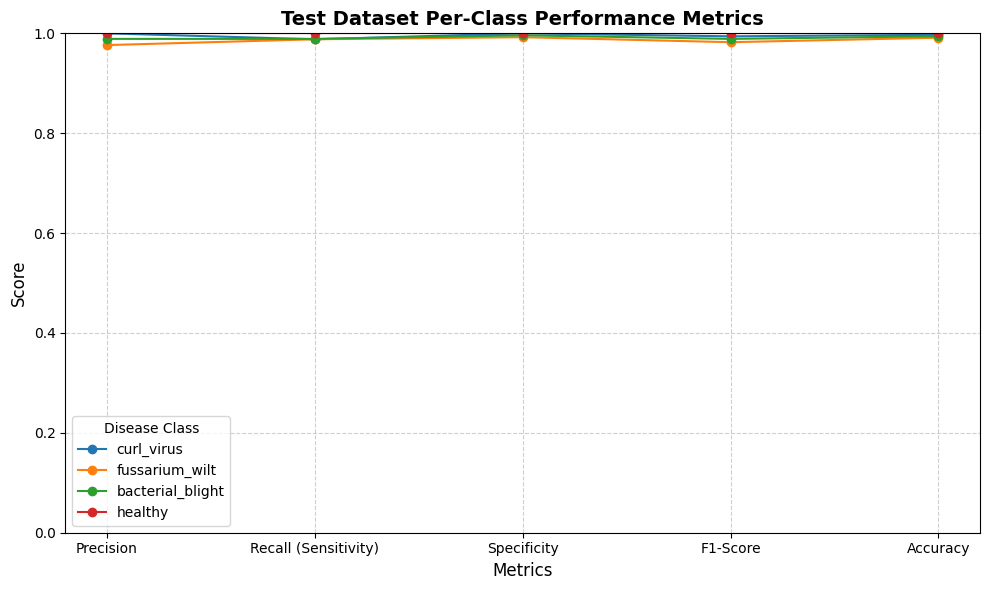

In [ ]:
metrics = ["Precision", "Recall (Sensitivity)", "Specificity", "F1-Score", "Accuracy"]

plt.figure(figsize=(10,6))

for idx, cls in enumerate(categories):
    cls_data = df_results[df_results["Class"] == cls].iloc[0]
    cls_values = [cls_data[m] for m in metrics]
    plt.plot(metrics, cls_values, marker='o', label=cls)

plt.title("Test Dataset Per-Class Performance Metrics", fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Disease Class")
plt.tight_layout()
plt.show()



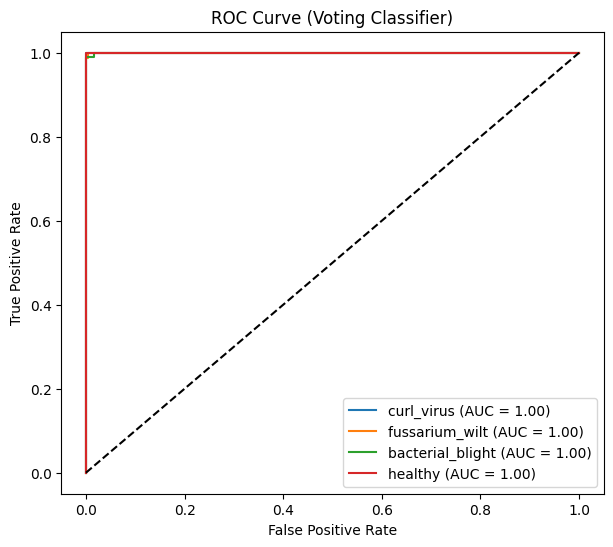

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=list(range(len(categories))))
y_prob = voting_clf.predict_proba(X_test_concat)

fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,6))
for i in range(len(categories)):
    plt.plot(fpr[i], tpr[i], label=f"{categories[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Voting Classifier)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Saving Screenshot 2025-11-04 101457.png to Screenshot 2025-11-04 101457.png
Uploaded file: /content/Screenshot 2025-11-04 101457.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


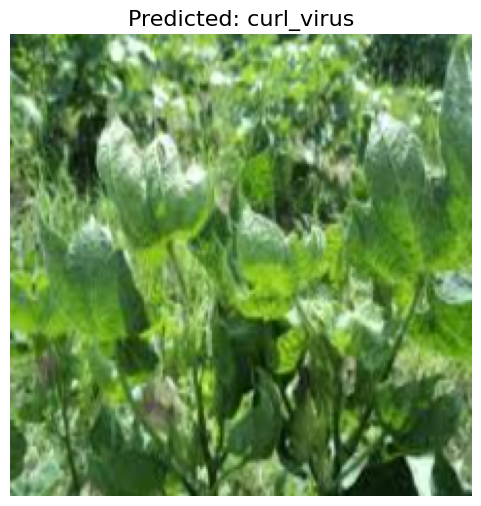

Prediction Probabilities:
curl_virus: 0.5697
fussarium_wilt: 0.3162
bacterial_blight: 0.0428
healthy: 0.0712


In [ ]:
from google.colab import files


img_size = 224
categories = ["curl_virus", "fussarium_wilt", "bacterial_blight", "healthy"]

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for matplotlib
    img_norm = img.astype("float32") / 255.0
    img_norm = np.expand_dims(img_norm, axis=0)  # Add batch dimension
    return img, img_norm

def extract_features_single(base_model, img):
    model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
    features = model.predict(img)
    return features

def predict_image(img_path):
    img_display, img_processed = preprocess_image(img_path)

    vgg_feat = extract_features_single(vgg_base, img_processed)
    resnet_feat = extract_features_single(resnet_base, img_processed)
    dense_feat = extract_features_single(dense_base, img_processed)

    concat_feat = np.concatenate([vgg_feat, resnet_feat, dense_feat], axis=1)

    pred_class_idx = voting_clf.predict(concat_feat)[0]
    pred_class = categories[pred_class_idx]

    pred_probs = voting_clf.predict_proba(concat_feat)[0]

    return img_display, pred_class, pred_probs

uploaded = files.upload()

for filename in uploaded.keys():
    test_image_path = "/content/" + filename
    print("Uploaded file:", test_image_path)

    img_display, pred_class, pred_probs = predict_image(test_image_path)

    plt.figure(figsize=(6,6))
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class}", fontsize=16)
    plt.show()

    print("Prediction Probabilities:")
    for cat, prob in zip(categories, pred_probs):
        print(f"{cat}: {prob:.4f}")
